# Classifying Footwear with Reverse Mapping and Equivariant QNNs

## Authors : Kieran McDowall, NQCC. Max Arnott, Zaiku.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from circuit_layers_equivarient import conv_circuit_equiv, conv_layer_equiv, pool_circuit_equiv, pool_layer_equiv, encode_image_to_quantum
from circuit_equivarient import eqv_circ
from qiskit_machine_learning.circuit.library import RawFeatureVector

algorithm_globals.random_seed = 12345

from matplotlib import pyplot
from keras.datasets import fashion_mnist
import numpy as np

2024-07-10 12:09:44.360403: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 12:09:44.404851: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 12:09:44.405752: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 12:09:45.164658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


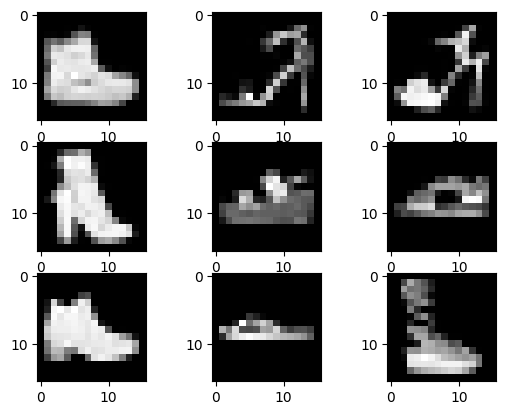

Training data length is: 200
Test / train split is: 0.3
Rescale successful
Rescale successful
Rescale successful
Rescale incorrect, norm/M is not less than 1. norm/M = 1.01627971205028
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale incorrect, norm/M is not less than 1. norm/M = 1.144638480045119
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale incorrect, norm/M is not less than 1. norm/M = 1.0963804298121158
Rescale incorrect, norm/M is not less than 1. norm/M = 1.0752602737244596
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Rescale successful
Resca

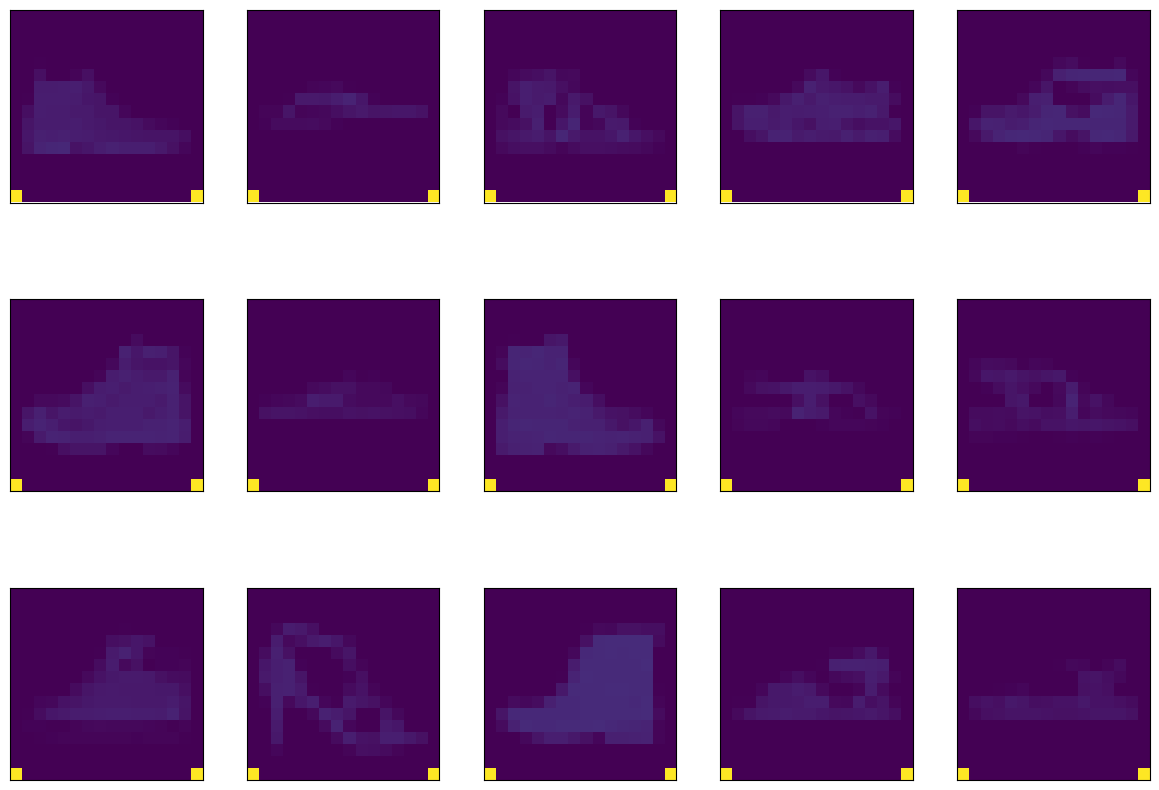

In [2]:
Map = 'Gnomonic'# 'Stereographic'#'Twilight'# #'Gnomonic'#'Orthographic'## ## # # #  
eqv = 'Eqv' # 'N-Eqv'
train_size = 200
test_size = 60
M = 2000
loss = 'cross_entropy' # 'cross_entropy''squared_error'
repeats = 20


# load dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
train_indices = []
test_indices = []
train_labels = []
test_labels = []

#selecting only boots and sandals from the dataset
for i in range(len(trainy)):
    if (trainy[i] == 5) or (trainy[i] == 9):
        train_indices.append(i)
    if trainy[i] == 5:
        train_labels.append(1)
    if trainy[i] == 9:
        train_labels.append(-1)
    
# print(len(train_labels))


for i in range(len(testy)):
    if (testy[i] == 5) or (testy[i] == 9): # 5 = sandal, 9 = boot
        test_indices.append(i)
    if testy[i] == 5:
        test_labels.append(1) # 1 = sandal
    if testy[i] == 9:
        test_labels.append(-1) # -1 = boot

    

#resizing
trainX_shoes_small = [trainX[i] for i in train_indices]
trainy_shoes = [trainy[i] for i in train_indices]
testX_shoes_small = [testX[i] for i in test_indices]
testy_shoes = [testy[i] for i in test_indices]

trainy_shoes = [1 if x == 5 else -1 for x in trainy_shoes]
testy_shoes = [1 if x == 5 else -1 for x in testy_shoes]

trainX_shoes = []
for i in range(len(trainX_shoes_small)):
  new_image = np.zeros((32, 32), dtype=trainX_shoes_small[i].dtype)
  new_image[2:-2, 2:-2] = trainX_shoes_small[i]
  trainX_shoes.append(new_image)

testX_shoes = []
for i in range(len(testX_shoes_small)):
  new_image = np.zeros((32, 32), dtype=testX_shoes_small[i].dtype)
  new_image[2:-2, 2:-2] = testX_shoes_small[i]
  testX_shoes.append(new_image)
  


# Define sample size
trainX_shoes = trainX_shoes[0:train_size]
train_labels = train_labels[0:train_size]
testX_shoes = testX_shoes[0:test_size]
test_labels = test_labels[0:test_size]


def pixelate_image(image):
    
    new_image = np.zeros((16, 16))
    
    for i in range(16):
        for j in range(16):
            
            new_image[i, j] = np.mean(image[i*2:(i+1)*2, j*2:(j+1)*2])
    
    return new_image


trainX_shoes16 = []
for i in range(len(trainX_shoes)):
    trainX_shoes16.append(pixelate_image(trainX_shoes[i]))
    

testX_shoes16 = []
for i in range(len(testX_shoes)):
    testX_shoes16.append(pixelate_image(testX_shoes[i])) 

  
import random
indices_to_flip_train = random.sample(range(len(trainX_shoes16)), len(trainX_shoes16) // 2)
indices_to_flip_test = random.sample(range(len(testX_shoes16)), len(testX_shoes16) // 2)

for index in indices_to_flip_train:
    # Flip the image horizontally
    trainX_shoes16[index] = trainX_shoes16[index][:, ::-1]

for index in indices_to_flip_test:
    # Flip the image horizontally
    testX_shoes16[index] = testX_shoes16[index][:, ::-1]

for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # plot raw pixel data
 pyplot.imshow(trainX_shoes16[i], cmap=pyplot.get_cmap('gray'))
# show the figure

pyplot.savefig('shoe_data_blackwhite.pdf', format='pdf', bbox_inches='tight')
pyplot.show()


print('Training data length is:', len(trainX_shoes16))
print('Test / train split is:', len(testX_shoes16)/len(trainX_shoes16))



#### 1) Need to flatten arrays
trainX_shoes_flat = []
testX_shoes_flat = []

for i in range(len(trainX_shoes16)):
    trainX_shoes_flat.append(trainX_shoes16[i].flatten())

for i in range(len(testX_shoes16)):    
    testX_shoes_flat.append(testX_shoes16[i].flatten())




def rescale(image,M):
    norm = np.linalg.norm(image)
    #10000

    if norm/M < 1:
        print('Rescale successful')

    else:
        print('Rescale incorrect, norm/M is not less than 1. norm/M =', norm/M)
        
    
    return image / M


trainX_shoes_flat = [rescale(array,M) for array in trainX_shoes_flat]
testX_shoes_flat = [rescale(array,M) for array in testX_shoes_flat]


#### 2) Now remove final coordinate from vectors
# trainX_shoes_flat[0].shape
# testX_shoes_flat

trainX_shoes_flat = [array[:-1] for array in trainX_shoes_flat]
testX_shoes_flat = [array[:-1] for array in testX_shoes_flat]


#### 3) Apply the reverse map projection

import functools


def inverse_orthographic(x):
    x_0 = np.sqrt( 1 - np.linalg.norm(x)**2)
    return x + [x_0]

def arbitrary_inverse_projection(a, x):
    # a should be the x_0 coordinate of the centre of projection. x belongs to the hyperplane
    s = np.linalg.norm(x)
    
    # this part handles the points which are outside of R_alpha
    if (a < -1) and (s > np.sqrt((a-1)/(a+1))):
        x = [ np.sqrt((a-1)/(a+1)) * x_i/s for x_i in x ]
        s = np.sqrt((a-1)/(a+1))
    
    #quadratic formula
    A = (s**2 + (1-a)**2)
    B = -2*a*s**2
    C = s**2 * a**2 - (1-a)**2
    
    x_0 = (-B + np.sqrt( B**2 - 4*A*C ))/ (2*A)
    
    return [ ((x_0 - a)/(1-a))*x_i for x_i in x ] + [x_0]


inverse_stereographic = functools.partial(arbitrary_inverse_projection, -1)
inverse_gnomonic = functools.partial(arbitrary_inverse_projection, 0)
inverse_twilight = functools.partial(arbitrary_inverse_projection, -1-np.sqrt(2)/2)
inverse_orthographic = functools.partial(inverse_orthographic)




trainX_shoes_final = []
testX_shoes_final = []


if Map == 'Orthographic':
    # alpha = -oo
    trainX_shoes_final = [np.append(array, np.sqrt(1-np.linalg.norm(array)**2)) for array in trainX_shoes_flat]   # np.sqrt(1-np.linalg.norm(array)**2)
    testX_shoes_final = [np.append(array, np.sqrt(1-np.linalg.norm(array)**2)) for array in testX_shoes_flat]   #

        
if Map == 'Gnomonic':
    # # alpha = 0
    for i in range(len(trainX_shoes_flat)):
        trainX_shoes_final.append(inverse_gnomonic(trainX_shoes_flat[i]))
        
    for i in range(len(testX_shoes_flat)):
        testX_shoes_final.append(inverse_gnomonic(testX_shoes_flat[i]))
 
if Map == 'Stereographic':
    # alpha = -1
    for i in range(len(trainX_shoes_flat)):
        trainX_shoes_final.append(inverse_stereographic(trainX_shoes_flat[i]))
        
    for i in range(len(testX_shoes_flat)):
        testX_shoes_final.append(inverse_stereographic(testX_shoes_flat[i]))

if Map == 'Twilight':
    # alpha = -1-np.sqrt(2)/2
    for i in range(len(trainX_shoes_flat)):
        trainX_shoes_final.append(inverse_twilight(trainX_shoes_flat[i]))
        
    for i in range(len(testX_shoes_flat)):
        testX_shoes_final.append(inverse_twilight(testX_shoes_flat[i]))


#### 5) for equivarient duplicate the last coord to syymetrically related position
# here we have 16x16 = 256, 3/4==192, index is 191
# For trainX_shoes_flat
for array in trainX_shoes_final:
    array[240] = array[-1] # correct is 240. before i had 191

# For testX_shoes_flat
for array in testX_shoes_final:
    array[240] = array[-1] # correct is 



from qiskit import QuantumCircuit, transpile, assemble

def normalize(image):
    norm = np.linalg.norm(image)
    return image / norm

def encode_image_to_quantum(image):
    # Flatten the image to a 1D array
    image = image.flatten()
    
    # Normalize the image pixel values to form a valid quantum state
    normalized_image = normalize(image)
    
    # Initialize a quantum circuit with 4 qubits
    num_qubits = 8
    qc = QuantumCircuit(num_qubits)
    
    # Prepare the quantum state from the normalized pixel values
    qc.initialize(normalized_image, range(num_qubits))
    
    return qc

# Let's see some examples in our dataset
fig, ax = plt.subplots(3, 5, figsize=(15, 10), subplot_kw={"xticks": [], "yticks": []})
for i in range(15):  # Adjusted for 3 rows and 5 columns (3*5 = 15)
    ax[i // 5, i % 5].imshow(np.asarray(testX_shoes_final[i]).reshape(16, 16), aspect="equal")    #, cmap='gray'
plt.subplots_adjust(wspace=0.1, hspace=0.5)

### Now want to ensure only equivarient gates are being used. Using twirling formula:

#### - On qubits 0,1,2,3,4, we may use RX gates, or entangling gates RYY, RZY, RXX, RZZ.
#### - On qubits 5,6,7,8,9, (corresponding to the y coordinate) we may use any rotation and entangling gates
#### - To entangle a qubit A from gates 0,1,2,3,4 with a qubit B from gates 5,6,7,8,9, we may use an RXX gate. A CNOT is possible as well, but only with the control as B. A can not be used as the control.

In [3]:
##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate, RXGate


## More expresive?! With rxx into ryys and rzzs 
def eqv_circ_eff(params):

    qc = QuantumCircuit(8)
    
    # Type A - within 0-3

    qc.rx(params[0], 0)
    qc.rx(params[1], 1)
    qc.rx(params[2], 2)
    qc.rx(params[3], 3)
    
    qc.ry(params[4], 4)
    qc.ry(params[5], 5)
    qc.ry(params[6], 6)
    qc.ry(params[7], 7)

    qc.rx(params[8], 0)
    qc.rx(params[9], 1)
    qc.rx(params[10], 2)
    qc.rx(params[11], 3)

    qc.rz(params[12], 4)
    qc.rz(params[13], 5)
    qc.rz(params[14], 6)
    qc.rz(params[15], 7)

    # Entangling
    qc.cx(6,7)
    qc.cx(5,6)
    qc.cx(4,5)
    qc.rxx(np.pi/2,3,4)
    qc.ryy(np.pi/2,2,3) # some of these can be ryy, rzz
    qc.rzz(np.pi/2,1,2)
    qc.rxx(np.pi/2,0,1)
    #####
    
    qc.rx(params[16], 0)
    qc.rx(params[17], 1)
    qc.rx(params[18], 2)
    qc.rx(params[19], 3)
    
    qc.ry(params[20], 4)
    qc.ry(params[21], 5)
    qc.ry(params[22], 6)
    qc.ry(params[23], 7)

    qc.rx(params[24], 0)
    qc.rx(params[25], 1)
    qc.rx(params[26], 2)
    qc.rx(params[27], 3)

    qc.rz(params[28], 4)
    qc.rz(params[29], 5)
    qc.rz(params[30], 6)
    qc.rz(params[31], 7)
    
    
    return qc


### View the amplitdue embedding circuit

In [ ]:
qubits = 8

feature_map = RawFeatureVector(2**qubits)

params = ParameterVector("θ", length=32)
# Initialize ansatz for 10 qubits
ansatz = eqv_circ_eff(params)


# Combining the feature map and ansatz
circuit = QuantumCircuit(qubits)
circuit.compose(feature_map, range(qubits), inplace=True)
circuit.compose(ansatz, range(qubits), inplace=True)

circvis = QuantumCircuit(qubits)
circvis.compose(ansatz, range(qubits), inplace=True)

# Adjust observable for 8 qubits
observable = SparsePauliOp.from_list([("X" * 4+ "Z" * 4, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

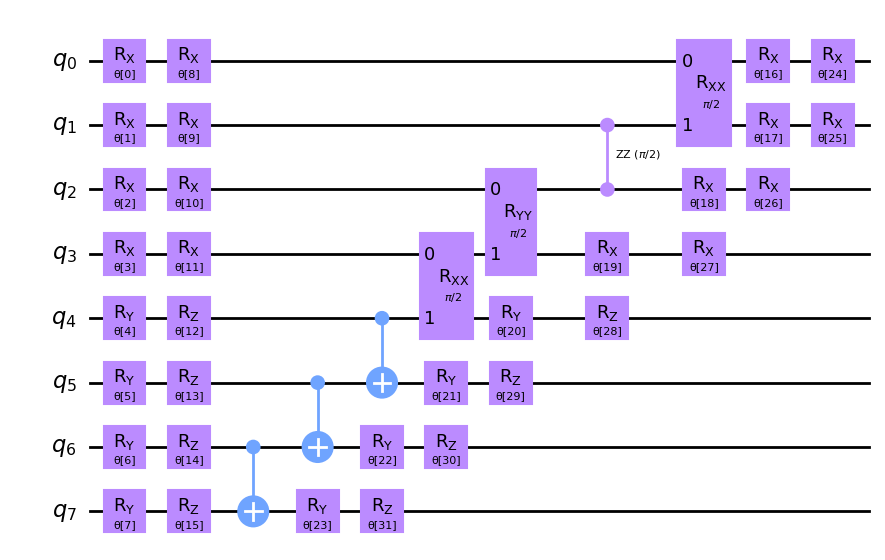

In [5]:
circvis.draw("mpl", style="clifford") #.decompose(reps=1)

In [6]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [7]:
iters = 200


classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=iters),  # Set max iterations here
    callback=callback_graph,
    loss=loss
    # initial_point=initial_point, # if you have one!!
)

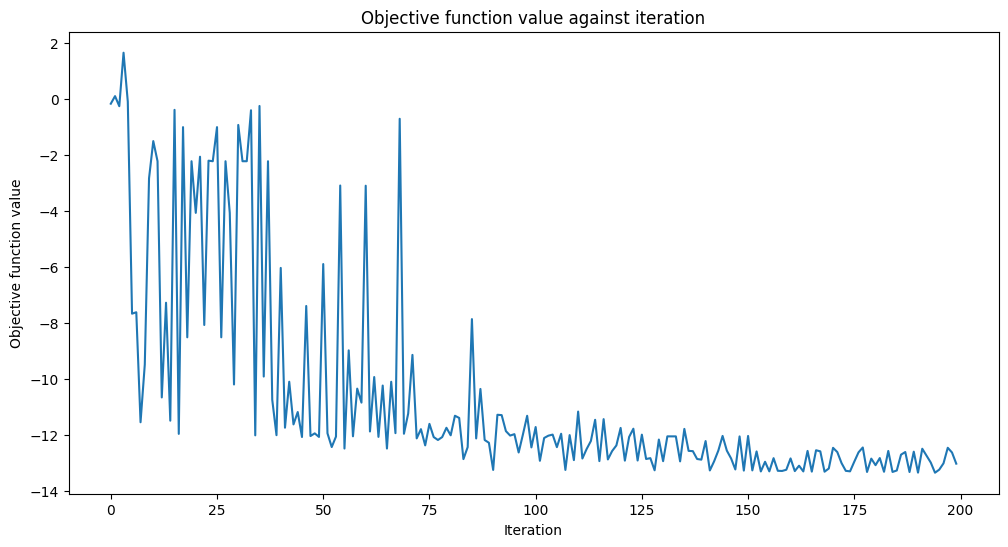

Accuracy from the train data : 91.67%
Accuracy from the test data : 91.67%


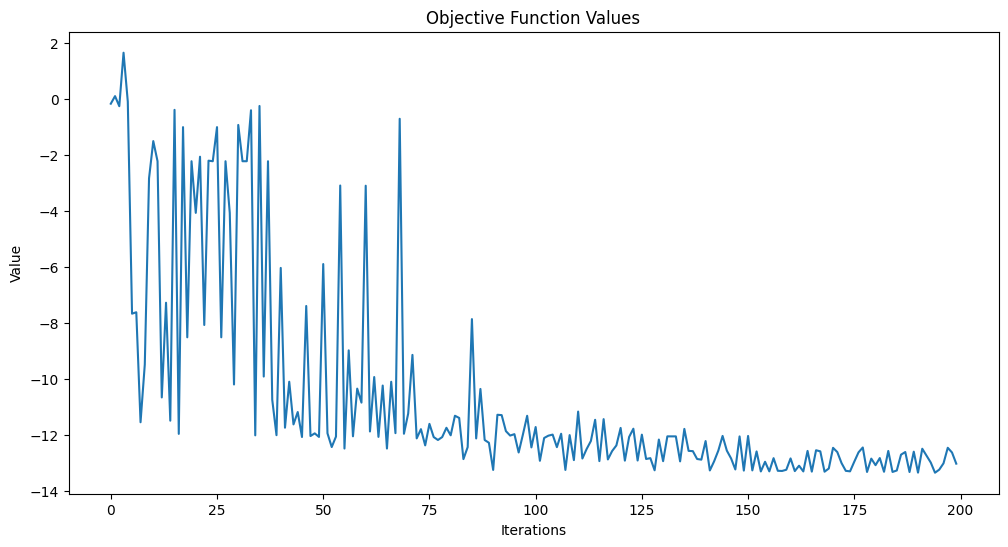

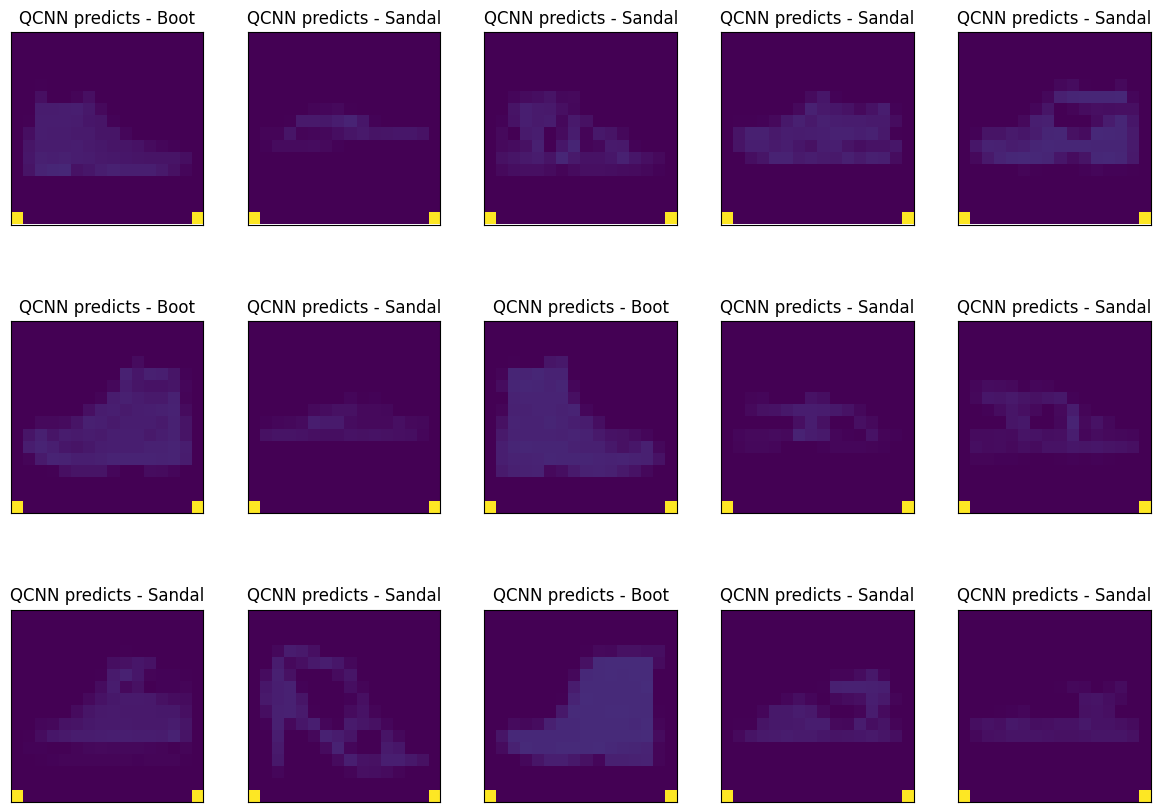

In [8]:
import timeit
import time
# Get the current date and time
# current_datetime = datetime.datetime.now()
timestr = time.strftime("%Y%m%d-%H%M%S")

x = np.asarray(trainX_shoes_final)
y = np.asarray(train_labels)



accum_objective_func_vals = []
train_accs = []
test_accs = []
train_times = []
test_times = []


for i in range(repeats):

    start = timeit.default_timer()
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)
    classifier.fit(x, y)
    stop = timeit.default_timer()
    train_time = stop - start
    
    train_times.append(train_time)
    
    # Create a plot (example plot, replace with your actual plot logic)
    plt.plot(objective_func_vals)
    plt.title('Objective Function Values')
    plt.xlabel('Iterations')
    plt.ylabel('Value')
    plt.savefig(f'Results_shoes/Final/loss{loss}_{eqv}_rep{i}_{Map}_N{qubits}_its{iters}_{timestr}.pdf', format='pdf', bbox_inches='tight')

    accum_objective_func_vals.append(objective_func_vals)
    
    train_acc = np.round(100 * classifier.score(x, y), 2)
    # score classifier
    print(f"Accuracy from the train data : {train_acc}%") 
    train_accs.append(train_acc)
    


    
    start = timeit.default_timer()
    y_predict = classifier.predict(testX_shoes_final)
    # Stop timer
    stop = timeit.default_timer()
    test_time = stop - start
    test_times.append(test_time)
    
    x = np.asarray(testX_shoes_final)
    y = np.asarray(test_labels)
    
    test_acc = np.round(100 * classifier.score(x, y), 2)
    print(f"Accuracy from the test data : {test_acc}%")
    test_accs.append(test_acc)
    
    # Let's see some examples in our dataset
    fig, ax = plt.subplots(3, 5, figsize=(15, 10), subplot_kw={"xticks": [], "yticks": []})
    for i in range(15):  # Adjusted for 3 rows and 5 columns (3*5 = 15)
        ax[i // 5, i % 5].imshow(np.asarray(testX_shoes_final[i]).reshape(16, 16), aspect="equal")    #, cmap='gray'
        if y_predict[i] == -1:
            ax[i // 5, i % 5].set_title("QCNN predicts - Boot")
        elif y_predict[i] == +1:
            ax[i // 5, i % 5].set_title("QCNN predicts - Sandal")
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    
    plt.savefig(f'Results_shoes/Final/predictions_{eqv}_rep{i}_{Map}_N{qubits}__its{iters}_{loss}_{timestr}.pdf', format='pdf', bbox_inches='tight')



In [9]:
train_test_size = len(testX_shoes_final) + len(trainX_shoes_final)
train_test_split_frac =  len(testX_shoes_final) / len(trainX_shoes_final)


accum_objective_func_vals = np.asarray(accum_objective_func_vals)


np.savetxt(f'Data/train_acc/loss{loss}_{eqv}_{Map}_data_N{qubits}_its{iters}_M{M}_size{train_size}_split{train_test_split_frac}_reps{repeats}_{timestr}.txt', accum_objective_func_vals, fmt='%.10f')


train_acc = np.average(train_accs)
test_acc = np.average(test_accs)
train_time = np.average(train_times)
test_time = np.average(test_times)

train_acc_std = np.std(train_accs)
test_acc_std = np.std(test_accs)
train_time_std = np.std(train_times)
test_time_std = np.std(test_times)

In [10]:
import pandas as pd 

# Create a dictionary with the data
data = {
    'Train Acc. avg': [train_acc],
    'Train Acc. std': [train_acc_std],
    'Test Acc.': [test_acc],
    'Test Acc. std': [test_acc_std],
    'Train time' : [train_time],
    'Train time std': [train_time_std],
    'Test time' : [test_time],
    'Test time std': [test_time_std],
    'Optimizer iterations' : [iters],
    'Train and test size' :[train_test_size],
    'Train and test split' :[train_test_split_frac],
    'M':[M],
    'Map':[Map],
    'Reps':[repeats]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv(f'Results_shoes/Final/accuracy_{eqv}_{Map}_data_N{qubits}_its{iters}_{loss}_{timestr}.csv', index=False)

# Display the DataFrame
print(df)

   Train Acc. avg  Train Acc. std  Test Acc.  Test Acc. std  Train time  \
0         91.5115        0.690885      91.67   1.421085e-14   247.67012   

   Train time std  Test time  Test time std  Optimizer iterations  \
0       50.719516   0.950991       0.260978                   200   

   Train and test size  Train and test split     M       Map  Reps  
0                  260                   0.3  2000  Gnomonic    20  
